# Learning How to read Data from kinesis using Python PyFlink

# Step 1 : Create Kinesis Streams 

In [20]:
import boto3


def create_kinesis_stream(stream_name, shard_count):
    try:
        # Initialize the Kinesis client
        kinesis_client = boto3.client('kinesis')

        # Create the Kinesis stream
        response = kinesis_client.create_stream(
            StreamName=stream_name,
            ShardCount=shard_count
        )

        # Check for successful response
        if response['ResponseMetadata']['HTTPStatusCode'] == 200:
            print(f"Kinesis stream '{stream_name}' created with {shard_count} shard(s)")
        else:
            print("Failed to create Kinesis stream")

    except Exception as e:
        print(f"Error: {str(e)}")

def delete_kinesis_stream(stream_name):
    try:
        # Initialize the Kinesis client
        kinesis_client = boto3.client('kinesis')

        # Delete the Kinesis stream
        response = kinesis_client.delete_stream(
            StreamName=stream_name
        )

        # Check for successful response
        if response['ResponseMetadata']['HTTPStatusCode'] == 200:
            print(f"Kinesis stream '{stream_name}' deleted successfully")
        else:
            print("Failed to delete Kinesis stream")

    except Exception as e:
        print(f"Error: {str(e)}")
        


In [21]:
create_kinesis_stream("input-stream", 1)
#create_kinesis_stream("output-stream", 1)

Kinesis stream 'input-stream' created with 1 shard(s)


# Step 2 : Publish some Dummy Data into Input Streams 

In [4]:
import datetime
import json
import random
import boto3

STREAM_NAME = "input-stream"


def get_data():
    return {
        'event_time': datetime.datetime.now().isoformat(),
        'ticker': random.choice(['AAPL', 'AMZN', 'MSFT', 'INTC', 'TBV']),
        'price': round(random.random() * 100, 2)
    }


def generate(stream_name, kinesis_client, num_samples):
    for _ in range(num_samples):
        data = get_data()
        print(data)
        kinesis_client.put_record(
            StreamName=stream_name,
            Data=json.dumps(data),
            PartitionKey="partitionkey")
if __name__ == '__main__':
    num_samples = 10  # Change this to the desired number of samples
    generate(STREAM_NAME, boto3.client('kinesis'), num_samples)


{'event_time': '2023-09-20T16:51:54.599131', 'ticker': 'AAPL', 'price': 85.26}
{'event_time': '2023-09-20T16:51:54.782422', 'ticker': 'TBV', 'price': 2.4}
{'event_time': '2023-09-20T16:51:54.813887', 'ticker': 'AMZN', 'price': 30.38}
{'event_time': '2023-09-20T16:51:54.847837', 'ticker': 'AAPL', 'price': 28.54}
{'event_time': '2023-09-20T16:51:54.881335', 'ticker': 'MSFT', 'price': 18.05}
{'event_time': '2023-09-20T16:51:54.915535', 'ticker': 'MSFT', 'price': 6.44}
{'event_time': '2023-09-20T16:51:54.950722', 'ticker': 'AMZN', 'price': 6.55}
{'event_time': '2023-09-20T16:51:54.991408', 'ticker': 'AAPL', 'price': 90.01}
{'event_time': '2023-09-20T16:51:55.025597', 'ticker': 'AMZN', 'price': 38.89}
{'event_time': '2023-09-20T16:51:55.059101', 'ticker': 'AMZN', 'price': 98.67}


# Step 3: Python Flink code 

##### Download JAR file flink-sql-connector-kinesis-1.16.1.jar and create file 
* https://mvnrepository.com/artifact/org.apache.flink/flink-sql-connector-kinesis/1.16.1

In [6]:
import os
os.listdir(".")

['.DS_Store',
 'lab2.ipynb',
 '.ipynb_checkpoints',
 'lab1.ipynb',
 'flink-sql-connector-kinesis-1.16.1.jar']

# Code Explanation 

This Python script demonstrates a PyFlink streaming application that processes data from a Kinesis Data Stream. Below are the key points explaining how the script works:

- It imports the necessary libraries, including PyFlink and os.
- It creates a PyFlink Table Environment (`table_env`) for stream processing.
- Configuration properties are defined in the `props` list. These properties include the Python script to execute and the JAR file for the Flink-Kinesis connector.
- The `property_map` function is used to extract property maps from the configuration properties.
- The `create_source_table` function generates a SQL definition for a source table that reads data from a Kinesis Data Stream.

In the `main` function:

- Application properties are extracted from the `props` list.
- The current working directory is obtained and used to set the JAR file path.
- A source table is created using the `create_source_table` function.
- Data is read from the source table and printed to the console.
- Depending on whether the environment variable `IS_LOCAL` is set, the Flink job is executed either synchronously or asynchronously, and the job status is printed.

Finally, the script is executed when run as the main program.

In [ ]:
# Import necessary libraries
from pyflink.table import EnvironmentSettings, TableEnvironment
import os

# 1. Create a Table Environment
env_settings = EnvironmentSettings.in_streaming_mode()
table_env = TableEnvironment.create(env_settings)

# Define configuration properties for the Flink job
props = [
    {
        "PropertyGroupId": "kinesis.analytics.flink.run.options",
        "PropertyMap": {
            "python": "GettingStarted/getting-started.py",  # Python script to be executed
            "jarfile": "flink-sql-connector-kinesis-1.16.1.jar"  # Flink connector JAR file
        }
    },
    {
        "PropertyGroupId": "consumer.config.0",
        "PropertyMap": {
            "input.stream.name": "input-stream",        # Name of the Kinesis Data Stream
            "flink.stream.initpos": "TRIM_HORIZON",     # Initial position to start reading the stream
            "aws.region": "us-east-1"                   # AWS region where the stream is located
        }
    }
]

# Function to extract property map from the configuration properties
def property_map(props, property_group_id):
    for prop in props:
        if prop["PropertyGroupId"] == property_group_id:
            return prop["PropertyMap"]

# Function to create a source table definition for Kinesis stream
def create_source_table(table_name, stream_name, region, stream_initpos):
    return f""" CREATE TABLE {table_name} (
                ticker VARCHAR(6),
                price DOUBLE,
                event_time TIMESTAMP(3),
                WATERMARK FOR event_time AS event_time - INTERVAL '5' SECOND
              )
              PARTITIONED BY (ticker)
              WITH (
                'connector' = 'kinesis',
                'stream' = '{stream_name}',
                'aws.region' = '{region}',
                'scan.stream.initpos' = '{stream_initpos}',
                'format' = 'json',
                'json.timestamp-format.standard' = 'ISO-8601'
              ) """

# Main function
def main():
    # Define keys for accessing properties
    input_property_group_key = "consumer.config.0"
    input_stream_key = "input.stream.name"
    input_region_key = "aws.region"
    input_starting_position_key = "flink.stream.initpos"

    # Table name for the source data
    input_table_name = "input_table"

    # Get application properties from the props list
    input_property_map = property_map(props, input_property_group_key)
    input_stream = input_property_map[input_stream_key]
    input_region = input_property_map[input_region_key]
    stream_initpos = input_property_map[input_starting_position_key]

    # Check if running in a local environment and set pipeline.jars configuration
    CURRENT_DIR = os.getcwd()  # Get the current working directory
    table_env.get_config().get_configuration().set_string(
        "pipeline.jars",
        "file:///" + CURRENT_DIR + "/flink-sql-connector-kinesis-1.16.1.jar",
    )

    # 2. Create a source table from a Kinesis Data Stream
    table_env.execute_sql(
        create_source_table(input_table_name, input_stream, input_region, stream_initpos)
    )

    print("Successfully created source tables ")

    # 3. Read data from the source table and print it to the console
    query = f"SELECT * FROM {input_table_name}"
    print(f"Executing query: {query}")
    table_env.execute_sql(query).print()

    if os.environ.get("IS_LOCAL"):
        # In a local environment, execute the job synchronously
        table_env.execute("Getting Started Job")
    else:
        # In a remote environment, execute the job asynchronously and print the job status
        job_client = table_env.execute_async("Getting Started Job")
        print(job_client.get_job_status())

# Entry point for the script
if __name__ == "__main__":
    main()


# Output 
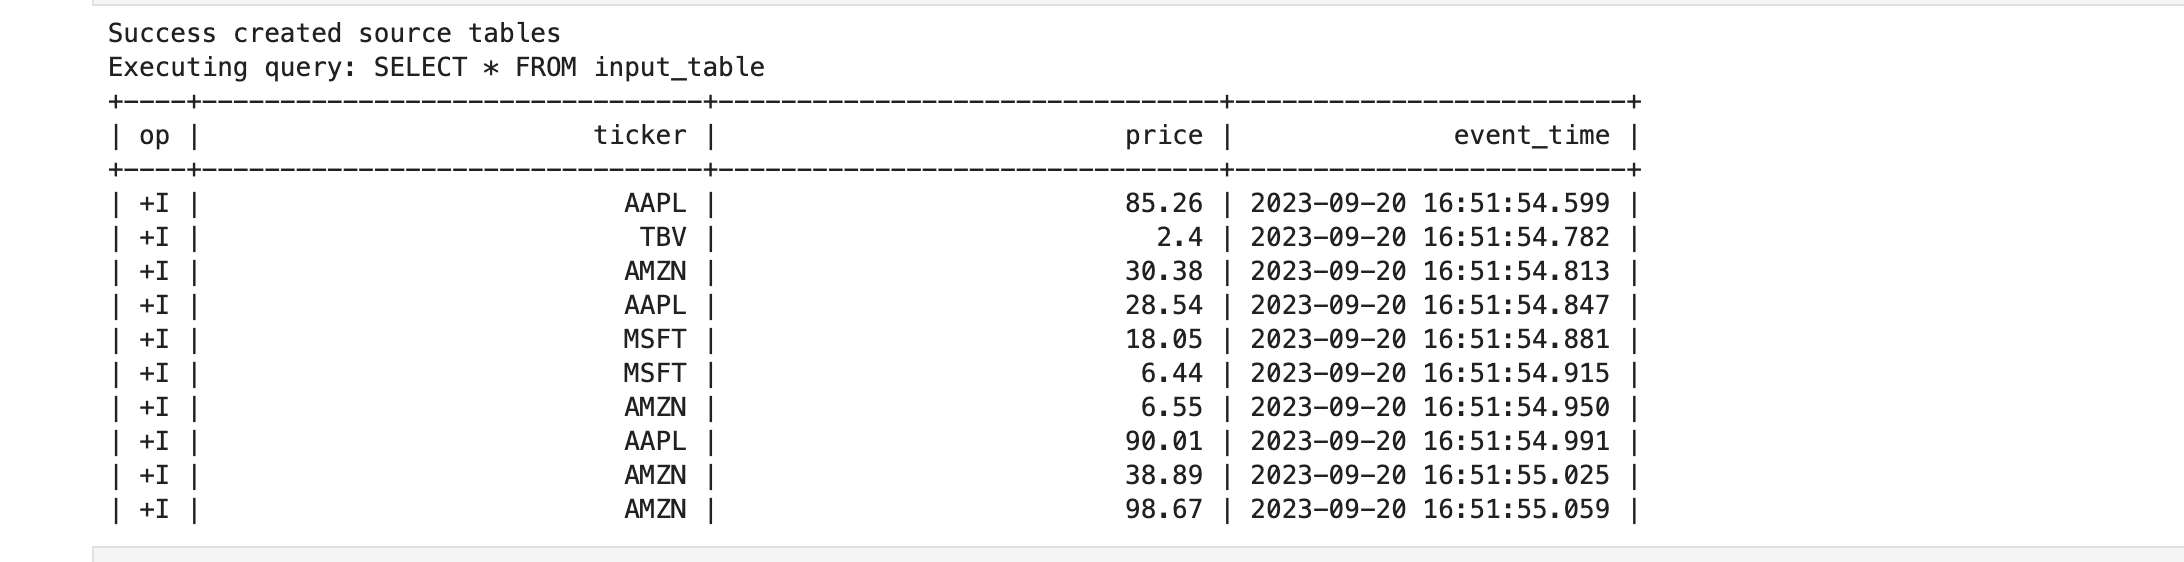

# Clean Up : Delete Kinesis

In [22]:
delete_kinesis_stream("input-stream")
delete_kinesis_stream("output-stream")

Kinesis stream 'input-stream' deleted successfully
Error: An error occurred (ResourceNotFoundException) when calling the DeleteStream operation: Stream output-stream under account 043916019468 not found.
